In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np #in realtà è usata

df = pd.read_csv("Excel/Biochemical_parameters.csv", names=["ID", "Data", "Parametro", "Valore"])

indici_da_droppare = df[df['Parametro'] == 'Name'].index
df = df.drop(indici_da_droppare)
df1 = df
df3 = df
df4 = df

df2 = pd.read_csv("Excel/Diagnostics.csv", names=["ID", "Codice", "Complicanza"])
df

ID        Data                         Parametro Valore
1      LIB193265  2018-09-05                         Potassium    4.5
2      LIB193265  2018-09-05                   HDL cholesterol   64.0
3      LIB193265  2018-09-05  Gamma-glutamyl Transferase (GGT)   11.0
4      LIB193265  2018-09-05                        Creatinine    0.9
5      LIB193265  2018-09-05                           Glucose  127.0
...          ...         ...                               ...    ...
87478  LIB194166  2022-02-10                         Potassium    4.2
87479  LIB194166  2022-02-10                        Creatinine   0.82
87480  LIB194166  2022-02-10                   HDL cholesterol   71.0
87481  LIB194166  2022-02-10                     Triglycerides  182.0
87482  LIB194166  2022-02-10                 Total cholesterol  207.0

[87482 rows x 4 columns]

In [2]:
def modified_z_score(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    if mad == 0:
        return np.zeros_like(series)
    return 0.6745 * (series - median) / mad

# Dizionario con unità, intervallo normale e intervallo fuori norma (ma possibili)
param_info = {
    "Creatinine": {"unit": "mg/dL", "normal": (0.6, 1.2), "abnormal": (1.3, 4.0)},
    "Glucose": {"unit": "mg/dL", "normal": (70, 100), "abnormal": ((0, 69), (101, 140))},
    "Potassium": {"unit": "mEq/L", "normal": (3.5, 5.0), "abnormal": ((0, 3.4), (5.1, 6.5))},
    "Sodium": {"unit": "mEq/L", "normal": (136, 146), "abnormal": ((0, 135), (147, 155))},
    "Alanine transaminase (GPT)": {"unit": "U/L", "normal": (7, 56), "abnormal": (57, 100)},
    "Gamma-glutamyl Transferase (GGT)": {"unit": "U/L", "normal": (8, 61), "abnormal": (62, 200)},
    "Total cholesterol": {"unit": "mg/dL", "normal": (0, 200), "abnormal": (201, 299)},
    "Triglycerides": {"unit": "mg/dL", "normal": (0, 150), "abnormal": (151, 500)},
    "HDL cholesterol": {"unit": "mg/dL", "normal": (40, None), "abnormal": (0, 39)},
    "Uric acid": {"unit": "mg/dL", "normal": (3.0, 8.2), "abnormal": ((0, 2.9), (8.3, 12.0))},
    "Glycated hemoglobin (A1c)": {"unit": "%", "normal": (0, 5.7), "abnormal": (5.8, 14.0)},
    "Thyrotropin (TSH)": {"unit": "µUI/L", "normal": (0.4, 4.0), "abnormal": (4.1, 20.0)},
    "Creatinine (urine)": {"unit": "mg/dL", "normal": (((29, 226), "donne"), ((40, 274), "uomini")), "abnormal": ((0, 29), (274, None))},
    "Albumin (urine)": {"unit": "mg/dL", "normal": (0, 30), "abnormal": (31, 300)},
    "Chlorine": {"unit": "mEq/L", "normal": (95, 105), "abnormal": ((0, 94), (106, 120))},
    "IA2 ANTIBODIES": {"unit": "U/mL", "normal": (0.0, 7.4), "abnormal": (7.5, 100.0)},
    "Insulin": {"unit": "µUI/mL", "normal": (2.6, 24.9), "abnormal": (25.0, 100.0)}
}

def analisi_parametri(df):
    summary = []
    outlier_ids_dict = {}  # <-- Nuovo dizionario per salvare gli outlier

    df = df[df["Parametro"] != "Name"]

    for nome, gruppo in df.groupby("Parametro"):
        gruppo = gruppo.reset_index(drop=True)  # Reset dell'indice per sicurezza
        valori = pd.to_numeric(gruppo["Valore"], errors='coerce')

        totale = len(valori)
        id_unici = gruppo["ID"].nunique()
        mancanti = 723 - id_unici

        min = valori.min()
        max = valori.max()
        mean = valori.mean()
        std_val = valori.std()

        # Modified Z-score
        z_scores = modified_z_score(valori)
        z_outliers_idx = np.where(np.abs(z_scores) > 5)[0]

        # Valori negativi
        valori_negativi_idx = valori[valori < 0].index

        # Unione degli outlier evitando doppioni
        outlier_idx_unici = set(z_outliers_idx).union(valori_negativi_idx)
        outliers = len(outlier_idx_unici)

        # Salvataggio degli ID outlier nel dizionario
        outlier_ids = gruppo.iloc[list(outlier_idx_unici)]["ID"].tolist()
        outlier_ids_dict[nome] = outlier_ids

        # Info aggiuntive
        info = param_info.get(nome, {})
        unit = info.get("unit", "")
        normal = info.get("normal", (None, None))
        abnormal = info.get("abnormal", None)

        summary.append([
            nome,
            unit,
            f"{normal[0]}–{normal[1] if normal[1] is not None else ''}",
            str(abnormal),
            totale,
            mancanti,
            min,
            mean,
            max,
            std_val,
            outliers,
        ])

    df_summary = pd.DataFrame(summary, columns=[
        "Parametro",
        "Unità",
        "Range Normale",
        "Range Fuori Norma (possibile)",
        "Valori Totali",
        "Persone senza esame",
        "Minimo",
        "Media",
        "Massimo",
        "Dev. Std",
        "Outliers",
    ])

    return df_summary, outlier_ids_dict

# Esegui e stampa
tabella_sintesi, outlier_ids_globali = analisi_parametri(df)
tabella_sintesi

Parametro   Unità  \
0         Alanine transaminase (GPT)     U/L   
1                    Albumin (urine)   mg/dL   
2                           Chlorine   mEq/L   
3                         Creatinine   mg/dL   
4                 Creatinine (urine)   mg/dL   
5   Gamma-glutamyl Transferase (GGT)     U/L   
6                            Glucose   mg/dL   
7          Glycated hemoglobin (A1c)       %   
8                    HDL cholesterol   mg/dL   
9                     IA2 ANTIBODIES    U/mL   
10                           Insulin  µUI/mL   
11                         Potassium   mEq/L   
12                            Sodium   mEq/L   
13                 Thyrotropin (TSH)   µUI/L   
14                 Total cholesterol   mg/dL   
15                     Triglycerides   mg/dL   
16                         Uric acid   mg/dL   

                                 Range Normale Range Fuori Norma (possibile)  \
0                                         7–56                     (57, 100)   
1                                         0–30                     (31, 300)   
2                                       95–105         ((0, 94), (106, 120))   
3                                      0.6–1.2                    (1.3, 4.0)   
4   ((29, 226), 'donne')–((40, 274), 'uomini')        ((0, 29), (274, None))   
5                                         8–61                     (62, 200)   
6                                       70–100         ((0, 69), (101, 140))   
7                                        0–5.7                   (5.8, 14.0)   
8                                          40–                       (0, 39)   
9                                      0.0–7.4                  (7.5, 100.0)   
10                                    2.6–24.9                 (25.0, 100.0)   
11                                     3.5–5.0        ((0, 3.4), (5.1, 6.5))   
12                                     136–146        ((0, 135), (147, 155))   
13                                     0.4–4.0                   (4.1, 20.0)   
14                                       0–200                    (201, 299)   
15                                       0–150                    (151, 500)   
16                                     3.0–8.2       ((0, 2.9), (8.3, 12.0))   

    Valori Totali  Persone senza esame   Minimo       Media  Massimo  \
0            7134                    1   -4.000   26.981679   868.00   
1            4283                   10    0.010    4.863133   992.20   
2            1935                  300   76.000  102.961395   136.00   
3            8495                    0    0.150    1.044406    11.55   
4            4412                   10    2.000  114.140306   543.46   
5            6085                    7    5.000   43.800016  2051.00   
6            8349                    0   10.000  163.035274   979.00   
7            4776                    3    4.000    7.823137    18.00   
8            5062                    6    7.000   56.626827   137.00   
9              66                  659    0.210  409.637424  6446.74   
10             64                  674    0.740   22.694688   298.50   
11           7853                    1    1.900    4.430804    22.60   
12           7814                    1  117.000  138.163053   168.00   
13           4570                    9    0.006    2.866165   204.89   
14           5954                    3   27.000  169.454825   703.00   
15           5791                    3   23.000  102.973925  3447.00   
16           4839                   15    1.000    4.392238    14.20   

       Dev. Std  Outliers  
0     44.617123       302  
1     26.560691         0  
2      5.339634         9  
3      0.947799       656  
4     66.798995         7  
5    113.549983       642  
6     85.403559        41  
7      1.385512        48  
8     14.367272         8  
9   1237.697950        25  
10    40.537998         6  
11     0.658540        37  
12     3.466266        32  
13     4.679146       108  
14  

In [3]:
def trova_outlier_globali(df):
    outlier_indices = []

    df = df[df["Parametro"] != "Name"]

    for nome, gruppo in df.groupby("Parametro"):
        gruppo = gruppo.copy()
        gruppo["Valore"] = pd.to_numeric(gruppo["Valore"], errors='coerce')
        valori = gruppo["Valore"]

        # Calcolo Modified Z-score
        z_scores = modified_z_score(valori)
        z_outliers = gruppo[np.abs(z_scores) > 5].index

        # Valori negativi
        negativi = gruppo[valori < 0].index

        # Unione degli outlier
        indici_outlier = z_outliers.union(negativi)
        outlier_indices.extend(indici_outlier)

    # Restituisce il sottoinsieme del DataFrame originale con solo gli outlier
    return df.loc[outlier_indices]

def analisi_parametri_secondario(df, outlier_ids_globali=None):
    summary = []
    
    df = df[df["Parametro"] != "Name"]

    for nome, gruppo in df.groupby("Parametro"):
        valori = pd.to_numeric(gruppo["Valore"], errors='coerce')
        totale = len(valori)
        id_unici = gruppo["ID"].nunique()
        mancanti = 723 - id_unici

        min_val = valori.min()
        max_val = valori.max()
        mean = valori.mean()
        std_val = valori.std()

        if outlier_ids_globali:
            outlier_ids = outlier_ids_globali.get(nome, set())
            outliers = gruppo["ID"].isin(outlier_ids).sum()
        else:
            z_scores = modified_z_score(valori)
            z_outliers_idx = np.where(np.abs(z_scores) > 5)[0]
            valori_negativi_idx = valori[valori < 0].index
            outlier_idx_unici = set(z_outliers_idx).union(valori_negativi_idx)
            outliers = len(outlier_idx_unici)

        info = param_info.get(nome, {})
        unit = info.get("unit", "")
        normal = info.get("normal", (None, None))
        abnormal = info.get("abnormal", None)

        summary.append([
            nome,
            unit,
            f"{normal[0]}–{normal[1] if normal[1] is not None else ''}",
            str(abnormal),
            totale,
            mancanti,
            min_val,
            mean,
            max_val,
            std_val,
            outliers,
        ])
    
    return pd.DataFrame(summary, columns=[
        "Parametro",
        "Unità",
        "Range Normale",
        "Range Fuori Norma (possibile)",
        "Valori Totali",
        "Persone senza esame",
        "Minimo",
        "Media",
        "Massimo",
        "Dev. Std",
        "Outliers",
    ])

ids_con_complicanze = df2["ID"].unique()

# 2. Dividiamo df1 in due dataset
df_con_complicanze = df1[df1["ID"].isin(ids_con_complicanze)]
df_senza_complicanze = df1[~df1["ID"].isin(ids_con_complicanze)]
print(len(df_con_complicanze))

tabella_con = analisi_parametri_secondario(df_con_complicanze, outlier_ids_globali)
tabella_senza = analisi_parametri_secondario(df_senza_complicanze, outlier_ids_globali)

tabella_con

67194


Parametro   Unità  \
0         Alanine transaminase (GPT)     U/L   
1                    Albumin (urine)   mg/dL   
2                           Chlorine   mEq/L   
3                         Creatinine   mg/dL   
4                 Creatinine (urine)   mg/dL   
5   Gamma-glutamyl Transferase (GGT)     U/L   
6                            Glucose   mg/dL   
7          Glycated hemoglobin (A1c)       %   
8                    HDL cholesterol   mg/dL   
9                     IA2 ANTIBODIES    U/mL   
10                           Insulin  µUI/mL   
11                         Potassium   mEq/L   
12                            Sodium   mEq/L   
13                 Thyrotropin (TSH)   µUI/L   
14                 Total cholesterol   mg/dL   
15                     Triglycerides   mg/dL   
16                         Uric acid   mg/dL   

                                 Range Normale Range Fuori Norma (possibile)  \
0                                         7–56                     (57, 100)   
1                                         0–30                     (31, 300)   
2                                       95–105         ((0, 94), (106, 120))   
3                                      0.6–1.2                    (1.3, 4.0)   
4   ((29, 226), 'donne')–((40, 274), 'uomini')        ((0, 29), (274, None))   
5                                         8–61                     (62, 200)   
6                                       70–100         ((0, 69), (101, 140))   
7                                        0–5.7                   (5.8, 14.0)   
8                                          40–                       (0, 39)   
9                                      0.0–7.4                  (7.5, 100.0)   
10                                    2.6–24.9                 (25.0, 100.0)   
11                                     3.5–5.0        ((0, 3.4), (5.1, 6.5))   
12                                     136–146        ((0, 135), (147, 155))   
13                                     0.4–4.0                   (4.1, 20.0)   
14                                       0–200                    (201, 299)   
15                                       0–150                    (151, 500)   
16                                     3.0–8.2       ((0, 2.9), (8.3, 12.0))   

    Valori Totali  Persone senza esame   Minimo       Media  Massimo  \
0            5545                  225   -4.000   28.036339   868.00   
1            3162                  228    0.120    5.705658   992.20   
2            1635                  407   76.000  102.986116   136.00   
3            6684                  225    0.150    1.088235    11.55   
4            3267                  228    2.000  106.331301   515.79   
5            4724                  228    5.000   46.240157  1903.00   
6            6547                  225   13.000  164.128914   790.00   
7            3490                  226    4.000    7.810946    16.40   
8            3787                  228    7.000   56.778189   132.00   
9              40                  683    0.210  182.815750  6446.74   
10             41                  692    0.740   21.626098   298.50   
11           6181                  226    1.900    4.452459    22.60   
12           6140                  226  117.000  138.094756   168.00   
13           3371                  231    0.006    2.925733   204.89   
14           4520                  227   27.000  169.472792   703.00   
15           4386                  227   23.000  107.182399  3447.00   
16           3674                  234    1.500    4.456543    14.20   

       Dev. Std  Outliers  
0     46.747188      1503  
1     29.828967         0  
2      5.533705       127  
3      1.025362      1095  
4     63.222186        24  
5    111.824547      1356  
6     84.477618       609  
7      1.353676       131  
8     14.687407        46  
9   1016.574265        13  
10    45.458724         1  
11     0.661280       893  
12     3.535835       519  
13     5.224457       397  
14  

In [4]:
tabella_senza

Parametro   Unità  \
0         Alanine transaminase (GPT)     U/L   
1                    Albumin (urine)   mg/dL   
2                           Chlorine   mEq/L   
3                         Creatinine   mg/dL   
4                 Creatinine (urine)   mg/dL   
5   Gamma-glutamyl Transferase (GGT)     U/L   
6                            Glucose   mg/dL   
7          Glycated hemoglobin (A1c)       %   
8                    HDL cholesterol   mg/dL   
9                     IA2 ANTIBODIES    U/mL   
10                           Insulin  µUI/mL   
11                         Potassium   mEq/L   
12                            Sodium   mEq/L   
13                 Thyrotropin (TSH)   µUI/L   
14                 Total cholesterol   mg/dL   
15                     Triglycerides   mg/dL   
16                         Uric acid   mg/dL   

                                 Range Normale Range Fuori Norma (possibile)  \
0                                         7–56                     (57, 100)   
1                                         0–30                     (31, 300)   
2                                       95–105         ((0, 94), (106, 120))   
3                                      0.6–1.2                    (1.3, 4.0)   
4   ((29, 226), 'donne')–((40, 274), 'uomini')        ((0, 29), (274, None))   
5                                         8–61                     (62, 200)   
6                                       70–100         ((0, 69), (101, 140))   
7                                        0–5.7                   (5.8, 14.0)   
8                                          40–                       (0, 39)   
9                                      0.0–7.4                  (7.5, 100.0)   
10                                    2.6–24.9                 (25.0, 100.0)   
11                                     3.5–5.0        ((0, 3.4), (5.1, 6.5))   
12                                     136–146        ((0, 135), (147, 155))   
13                                     0.4–4.0                   (4.1, 20.0)   
14                                       0–200                    (201, 299)   
15                                       0–150                    (151, 500)   
16                                     3.0–8.2       ((0, 2.9), (8.3, 12.0))   

    Valori Totali  Persone senza esame   Minimo       Media  Massimo  \
0            1589                  499    6.000   23.301322   709.00   
1            1121                  505    0.010    2.486628   354.07   
2             300                  616   86.000  102.826667   121.00   
3            1811                  498    0.300    0.882645     5.34   
4            1145                  505   12.000  136.421546   543.46   
5            1361                  502    5.000   35.330345  2051.00   
6            1802                  498   10.000  159.061876   979.00   
7            1286                  500    4.700    7.856221    18.00   
8            1275                  501   20.000   56.177255   137.00   
9              26                  699    0.280  758.593846  5683.21   
10             23                  705    1.530   24.599565   105.34   
11           1672                  498    2.500    4.350748    20.20   
12           1674                  498  121.000  138.413560   165.00   
13           1199                  501    0.008    2.698688    63.50   
14           1434                  499   84.000  169.398194   338.00   
15           1405                  499   23.000   89.836299  1151.00   
16           1165                  504    1.000    4.189442    12.10   

       Dev. Std  Outliers  
0     35.987192       136  
1     13.352830         0  
2      4.129584         0  
3      0.548145       104  
4     71.572846        16  
5    119.000301       183  
6     88.596858       184  
7      1.468472        62  
8     13.366702         3  
9   1470.316832        12  
10    30.703605         5  
11     0.642190        98  
12     3.186652        60  
13     2.585104        67  
14  

<Figure size 1400x800 with 0 Axes>

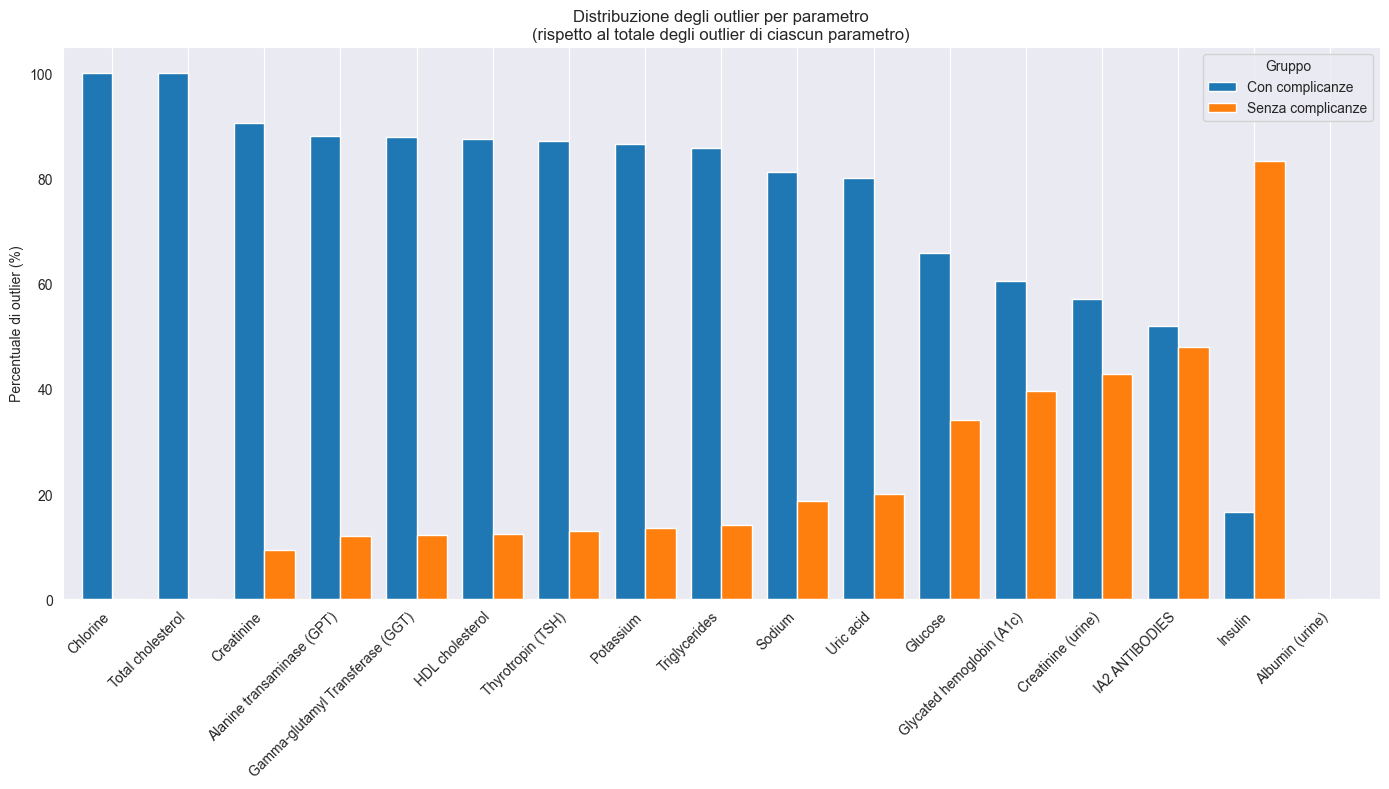

In [5]:
def calcola_percentuali_outlier_rispetto_al_totale(df_completo, df_con, df_senza):
    percentuali_con = {}
    percentuali_senza = {}

    for parametro, gruppo in df_completo.groupby("Parametro"):
        # Converti i valori a numerico e rimuovi NaN
        valori = pd.to_numeric(gruppo["Valore"], errors="coerce").dropna()
        if valori.empty:
            percentuali_con[parametro] = 0.0
            percentuali_senza[parametro] = 0.0
            continue

        # Calcola z-score modificato e individua gli outlier
        z_scores = modified_z_score(valori)
        outlier_mask = np.abs(z_scores) > 5

        # Filtra il gruppo originale per ottenere solo gli outlier
        outliers = gruppo[outlier_mask]

        totale_outliers = len(outliers)
        if totale_outliers == 0:
            percentuali_con[parametro] = 0.0
            percentuali_senza[parametro] = 0.0
            continue

        # Conta quanti outlier appartengono a ciascun sotto-gruppo
        outliers_con = outliers[outliers.index.isin(df_con.index)]
        outliers_senza = outliers[outliers.index.isin(df_senza.index)]

        percentuali_con[parametro] = 100 * len(outliers_con) / totale_outliers
        percentuali_senza[parametro] = 100 * len(outliers_senza) / totale_outliers

    return (
        pd.Series(percentuali_con, name="Con complicanze"),
        pd.Series(percentuali_senza, name="Senza complicanze")
    )

# Calcola percentuali rispetto al totale di outlier per ogni parametro
percentuali_con, percentuali_senza = calcola_percentuali_outlier_rispetto_al_totale(
    df1, df_con_complicanze, df_senza_complicanze
)

# Combina i risultati
df_outliers = pd.concat([percentuali_con, percentuali_senza], axis=1).fillna(0)
df_outliers = df_outliers.sort_values(by="Con complicanze", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
df_outliers.plot(kind="bar", figsize=(14, 8), width=0.8)
plt.ylabel("Percentuale di outlier (%)")
plt.title("Distribuzione degli outlier per parametro\n(rispetto al totale degli outlier di ciascun parametro)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.legend(title="Gruppo")
plt.show()

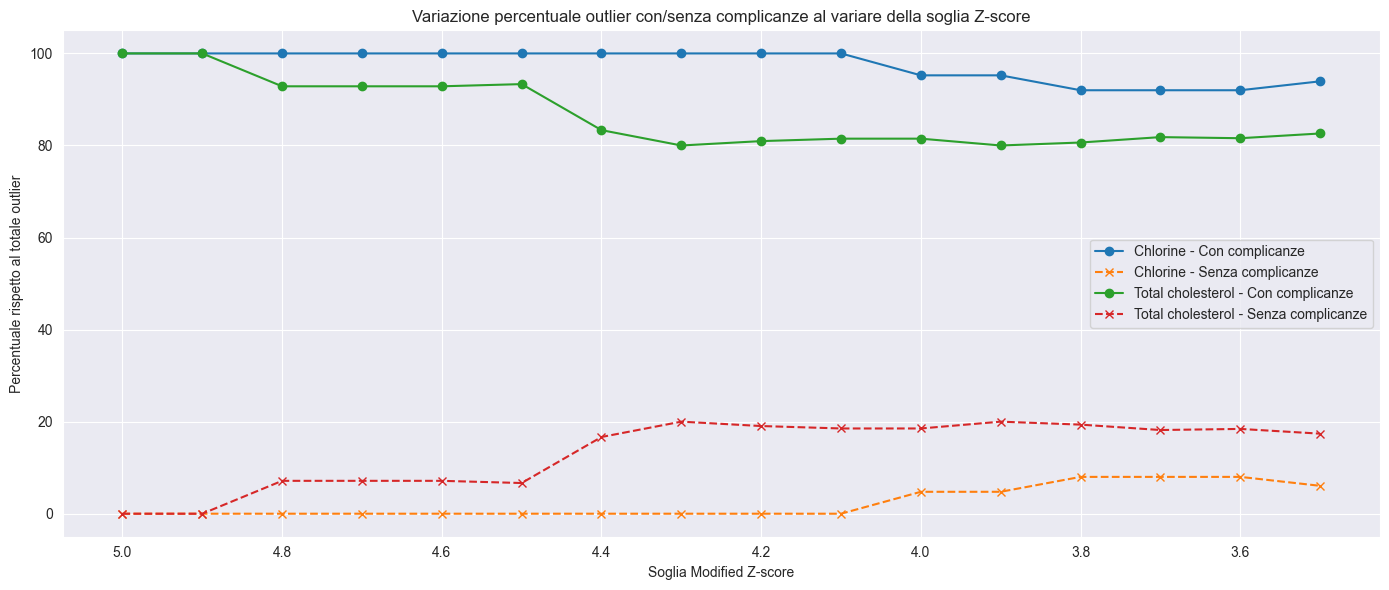

In [6]:
def analizza_andamento_outlier(df_completo, df_con, df_senza, parametri, soglie):
    risultati = []

    for soglia in soglie:
        for parametro in parametri:
            gruppo = df_completo[df_completo["Parametro"] == parametro]
            valori = pd.to_numeric(gruppo["Valore"], errors="coerce").dropna()
            if len(valori) == 0:
                continue

            z_scores = modified_z_score(valori)
            outlier_mask = np.abs(z_scores) > soglia
            outliers = gruppo[outlier_mask]

            totale_outliers = len(outliers)
            if totale_outliers == 0:
                percent_con = 0.0
                percent_senza = 0.0
            else:
                outliers_con = outliers[outliers.index.isin(df_con.index)]
                outliers_senza = outliers[outliers.index.isin(df_senza.index)]
                percent_con = 100 * len(outliers_con) / totale_outliers
                percent_senza = 100 * len(outliers_senza) / totale_outliers

            risultati.append({
                "Parametro": parametro,
                "Soglia": soglia,
                "Con complicanze": percent_con,
                "Senza complicanze": percent_senza,
                "Totale outlier": totale_outliers
            })

    return pd.DataFrame(risultati)

# Parametri da analizzare
parametri_da_studiare = ["Chlorine", "Total cholesterol"]
soglie = np.arange(5.0, 3.4, -0.1)  # Da 5.0 a 3.5 con passo -0.1

# Calcolo
df_risultati = analizza_andamento_outlier(df1, df_con_complicanze, df_senza_complicanze, parametri_da_studiare, soglie)

plt.figure(figsize=(14, 6))
for parametro in parametri_da_studiare:
    subset = df_risultati[df_risultati["Parametro"] == parametro]
    plt.plot(subset["Soglia"], subset["Con complicanze"], label=f"{parametro} - Con complicanze", marker='o')
    plt.plot(subset["Soglia"], subset["Senza complicanze"], label=f"{parametro} - Senza complicanze", linestyle='--', marker='x')

plt.gca().invert_xaxis()  # Inverti asse X per mostrare la soglia decrescente
plt.xlabel("Soglia Modified Z-score")
plt.ylabel("Percentuale rispetto al totale outlier")
plt.title("Variazione percentuale outlier con/senza complicanze al variare della soglia Z-score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\gabry\AppData\Local\Temp\ipykernel_28088\2816494865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_complicanze["Complicanze"] = "Con complicanze"
C:\Users\gabry\AppData\Local\Temp\ipykernel_28088\2816494865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_senza_complicanze["Complicanze"] = "Senza complicanze"


U-statistic = 36.50
p-value      = 0.7529


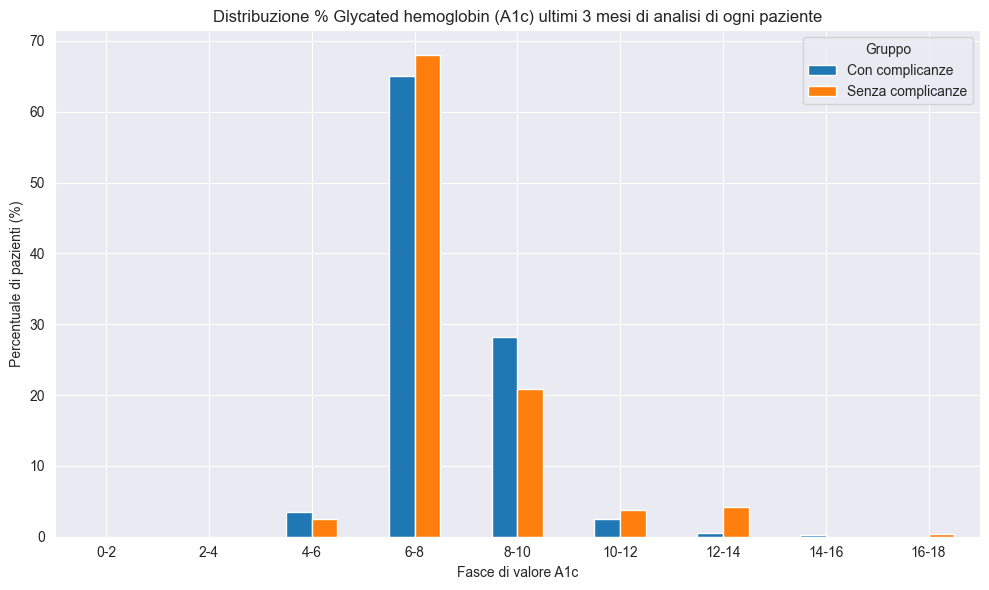

In [7]:
from datetime import timedelta
from scipy.stats import mannwhitneyu
from scipy.stats import skew, kurtosis

# 0. Unisci i due dataset, aggiungendo la colonna "Complicanze"
df_con_complicanze["Complicanze"] = "Con complicanze"
df_senza_complicanze["Complicanze"] = "Senza complicanze"
df_all = pd.concat([df_con_complicanze, df_senza_complicanze], ignore_index=True)

# 1. Filtra solo i valori A1c
df_all = df_all[df_all["Parametro"] == "Glycated hemoglobin (A1c)"]

# 2. Conversioni: numerico e datetime
df_all["Valore"] = pd.to_numeric(df_all["Valore"], errors="coerce")
df_all["Data"] = pd.to_datetime(df_all["Data"], errors="coerce")
df_all = df_all.dropna(subset=["Valore", "Data", "ID"])

# 3. Applica la maschera: ultimi 3 mesi per ciascun paziente
ultimi_tre_mesi = []
for id_, group in df_all.groupby("ID"):
    data_max = group["Data"].max()
    cutoff = data_max - timedelta(days=90)
    ultimi_tre_mesi.append(group[group["Data"] >= cutoff])

df_a1c_filtrato = pd.concat(ultimi_tre_mesi)

# 4. Separa i gruppi
a1c_con = df_a1c_filtrato[df_a1c_filtrato["Complicanze"] == "Con complicanze"]["Valore"]
a1c_senza = df_a1c_filtrato[df_a1c_filtrato["Complicanze"] == "Senza complicanze"]["Valore"]

# 5. Definisci fasce 0–2, 2–4, ..., 16–18
bins = np.arange(0, 20, 2)
labels = [f"{i}-{i+2}" for i in bins[:-1]]

# 6. Fasce con pd.cut()
a1c_con_binned = pd.cut(a1c_con, bins=bins, labels=labels, right=False)
a1c_senza_binned = pd.cut(a1c_senza, bins=bins, labels=labels, right=False)

# 7. Frequenze normalizzate
freq_con = a1c_con_binned.value_counts(normalize=True).sort_index() * 100
freq_senza = a1c_senza_binned.value_counts(normalize=True).sort_index() * 100

# 8. DataFrame per il grafico
df_plot = pd.DataFrame({
    "Con complicanze": freq_con,
    "Senza complicanze": freq_senza
})

u_stat, p_value = mannwhitneyu(freq_con, freq_senza, alternative='two-sided')
print(f"U-statistic = {u_stat:.2f}")
print(f"p-value      = {p_value:.4f}")

# 9. Plot
df_plot.plot(kind="bar", figsize=(10, 6))
plt.title("Distribuzione % Glycated hemoglobin (A1c) ultimi 3 mesi di analisi di ogni paziente")
plt.xlabel("Fasce di valore A1c")
plt.ylabel("Percentuale di pazienti (%)")
plt.xticks(rotation=0)
plt.legend(title="Gruppo")
plt.tight_layout()
plt.show()

In [8]:
df1["Data"] = pd.to_datetime(df1["Data"])

# Ottieni la prima data per ogni parametro per ciascun paziente
first_dates = df1.groupby(["ID", "Parametro"])["Data"].min().reset_index()
first_dates

ID                   Parametro       Data
0      LIB193265  Alanine transaminase (GPT) 2018-09-05
1      LIB193265             Albumin (urine) 2021-01-18
2      LIB193265                    Chlorine 2018-09-05
3      LIB193265                  Creatinine 2018-09-05
4      LIB193265          Creatinine (urine) 2021-01-18
...          ...                         ...        ...
10584  LIB194166                      Sodium 2020-12-10
10585  LIB194166           Thyrotropin (TSH) 2020-12-10
10586  LIB194166           Total cholesterol 2020-12-10
10587  LIB194166               Triglycerides 2020-12-10
10588  LIB194166                   Uric acid 2022-02-10

[10589 rows x 3 columns]

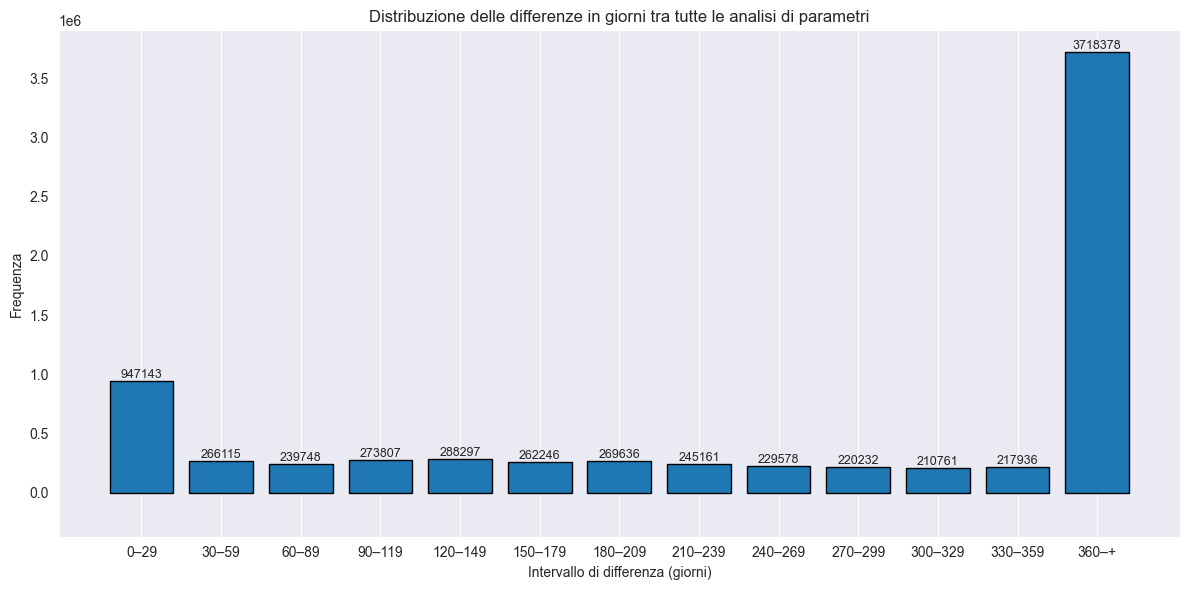

In [9]:
from itertools import combinations

records = []

# Supponiamo che 'all_dates' contenga tutte le osservazioni con colonne: ID, Parametro, Data
for patient_id, group in df1.groupby("ID"):
    # Per ogni paziente, raggruppa per parametro
    param_date_dict = {
        param: list(dates) for param, dates in group.groupby("Parametro")["Data"]
    }

    # Tutte le combinazioni di parametri
    for (p1, p2) in combinations(param_date_dict.keys(), 2):
        for d1 in param_date_dict[p1]:
            for d2 in param_date_dict[p2]:
                delta = abs((d1 - d2).days)
                records.append({
                    "ID": patient_id,
                    "Parametro 1": p1,
                    "Parametro 2": p2,
                    "Differenza giorni": delta
                })

df_diff = pd.DataFrame(records)

# 🎯 Definizione intervalli
bin_ranges = [(i, i+29) for i in range(0, 360, 30)]
bin_ranges.append((360, float('inf')))  # Ultimo intervallo: 360+

bin_labels = [f"{start}–{end if end != float('inf') else '+'}" for start, end in bin_ranges]

bin_counts = []
for start, end in bin_ranges:
    count = df_diff[
        (df_diff["Differenza giorni"] >= start) & 
        (df_diff["Differenza giorni"] <= end if end != float('inf') else True)
    ].shape[0]
    bin_counts.append(count)

# 🎨 Grafico
plt.figure(figsize=(12, 6))
bars = plt.bar(bin_labels, bin_counts, edgecolor='black')

for bar, count in zip(bars, bin_counts):
    x = bar.get_x() + bar.get_width() / 2
    if count > 0:
        plt.text(x, count, str(count), ha='center', va='bottom', fontsize=9)

plt.title("Distribuzione delle differenze in giorni tra tutte le analisi di parametri")
plt.xlabel("Intervallo di differenza (giorni)")
plt.ylabel("Frequenza")
plt.grid(axis='y')
plt.tight_layout()
plt.ylim(bottom=-max(bin_counts)*0.1)
plt.show()

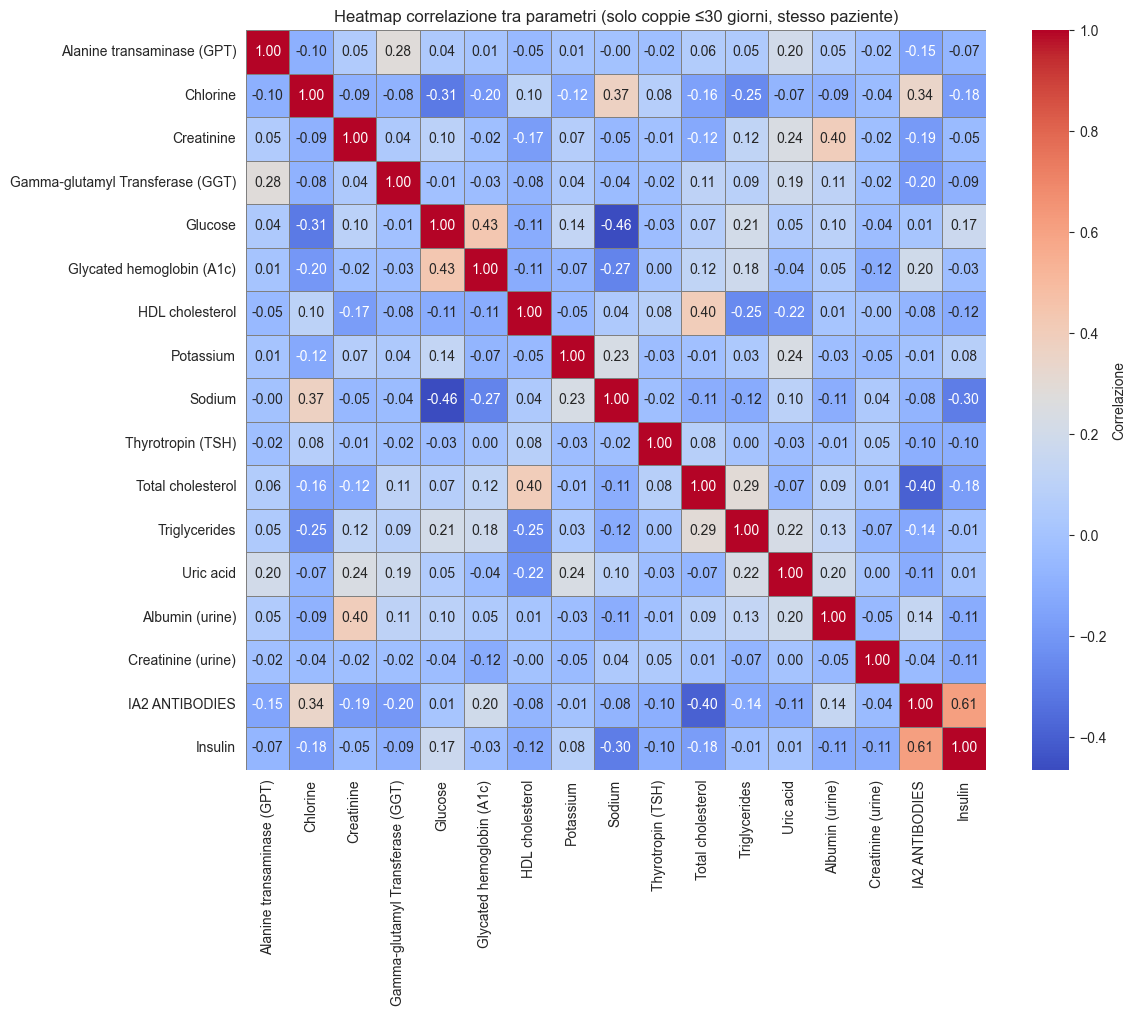

In [10]:
records = []

# Analisi per paziente
for patient_id, group in first_dates.groupby("ID"):
    # Dizionari per data e valore per parametro
    date_dict = group.set_index("Parametro")["Data"].to_dict()
    value_dict = df1[df1["ID"] == patient_id].groupby("Parametro")["Valore"].first().to_dict()

    for p1, p2 in combinations(date_dict.keys(), 2):
        delta_days = abs((date_dict[p1] - date_dict[p2]).days)
        if delta_days <= 30:
            val1 = pd.to_numeric(value_dict.get(p1), errors="coerce")
            val2 = pd.to_numeric(value_dict.get(p2), errors="coerce")
            if pd.notna(val1) and pd.notna(val2):
                records.append({
                    "ID": patient_id,
                    p1: val1,
                    p2: val2
                })

# Trasforma in DataFrame
df_corr_raw = pd.DataFrame(records)

# Raggruppa per ID e calcola la media dei valori duplicati
df_corr_wide = df_corr_raw.groupby("ID").mean(numeric_only=True)

# Calcola matrice di correlazione
correlation_matrix = df_corr_wide.corr()

# Plot della heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={'label': 'Correlazione'}, linewidths=0.5, linecolor='gray')
plt.title("Heatmap correlazione tra parametri (solo coppie ≤30 giorni, stesso paziente)")
plt.tight_layout()
plt.show()

C:\Users\gabry\AppData\Local\Temp\ipykernel_28088\2325961395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_complicanze["Complicanze"] = "Con complicanze"
C:\Users\gabry\AppData\Local\Temp\ipykernel_28088\2325961395.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_senza_complicanze["Complicanze"] = "Senza complicanze"


87482
12365


IndexError: index 104 is out of bounds for axis 0 with size 104

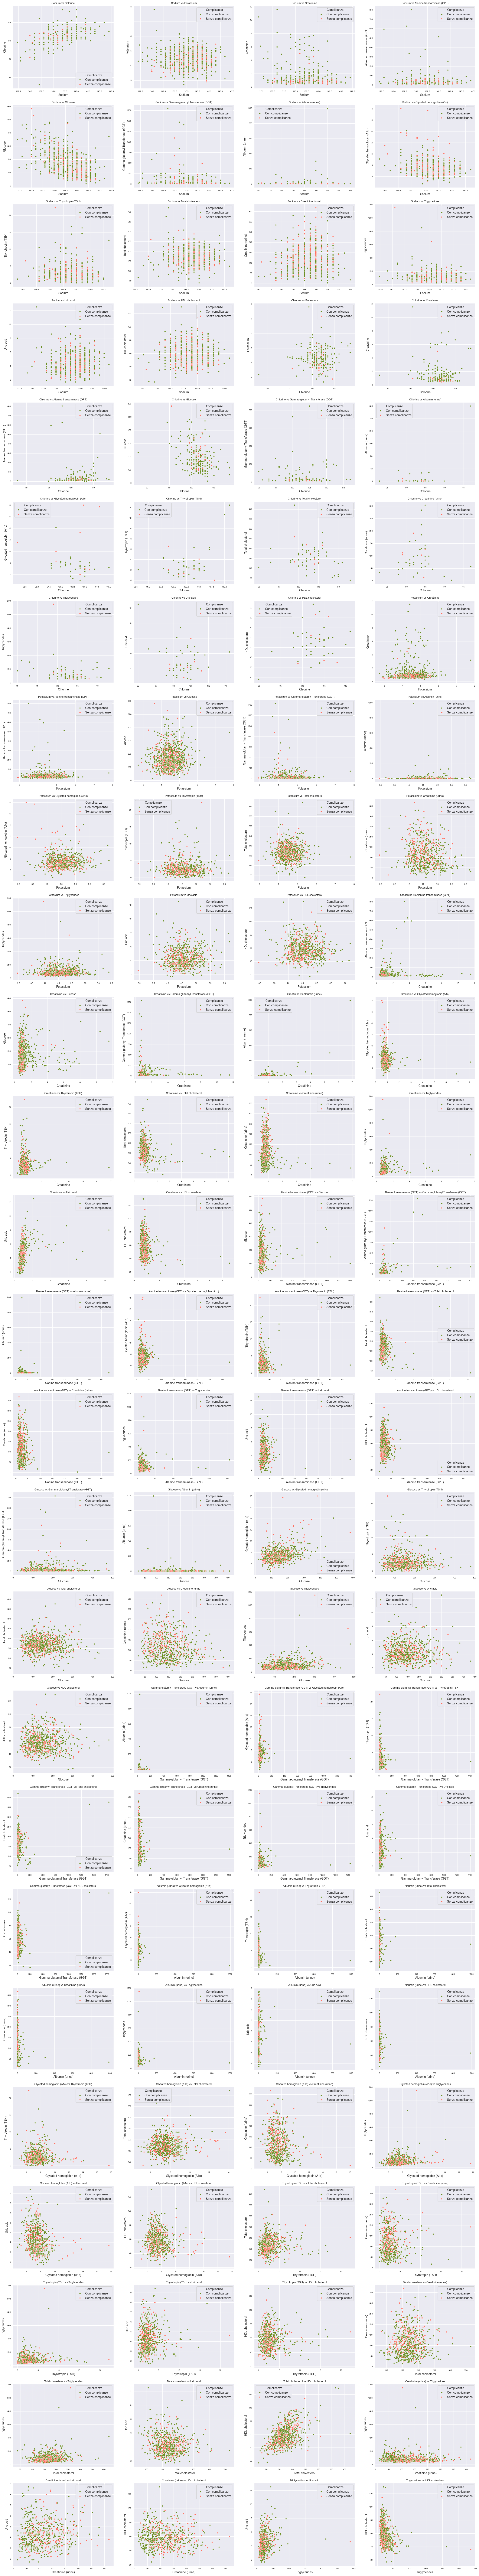

In [11]:
from itertools import combinations
from datetime import datetime, timedelta

# Parametri interessanti dalla heatmap (puoi modificarli o estenderli)
#combinazioni_interessanti = [
#    ("Chlorine", "Sodium"),
    #("Chlorine", "IA2 ANTIBODIES"),
#    ("Creatinine", "Albumin (urine)"),
#    ("Glucose", "Glycated hemoglobin (A1c)"),
#    ("Sodium", "Glucose"),  # Correlazione negativa
#    ("Total cholesterol", "Triglycerides")
    #("Total cholesterol", "IA2 ANTIBODIES"), # Correlazione negativa
    #("IA2 ANTIBODIES", "Insulin")
#]

# Crea la colonna "Complicanze"
df_con_complicanze["Complicanze"] = "Con complicanze"
df_senza_complicanze["Complicanze"] = "Senza complicanze"

# Unione dei due dataset
df_merged = pd.concat([df_con_complicanze, df_senza_complicanze], ignore_index=True)

# Parametri da escludere
parametri_da_escludere = {"Insulin", "IA2 ANTIBODIES"}

# Lista di tutti i parametri unici presenti nel dataset
parametri_unici = df_merged["Parametro"].unique()

# Tutte le combinazioni possibili escludendo quelle con parametri indesiderati
combinazioni_interessanti = [
    (p1, p2) for p1, p2 in combinations(parametri_unici, 2)
    if p1 not in parametri_da_escludere and p2 not in parametri_da_escludere
]

# Conversione a numerico e datetime
df_merged["Valore"] = pd.to_numeric(df_merged["Valore"], errors="coerce")
df_merged["Data"] = pd.to_datetime(df_merged["Data"], errors="coerce")

ultimi_tre_mesi = []

for patient_id, group in df_merged.groupby("ID"):
    data_max = group["Data"].max()
    cutoff_date = data_max - timedelta(days=90)
    ultimi_tre_mesi.append(group[group["Data"] >= cutoff_date])

df_merged1 = pd.concat(ultimi_tre_mesi)
print(len(df_merged))
print(len(df_merged1))

# Prepara i subplot
n = len(combinazioni_interessanti)
cols = 4
rows = (n + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 6 * rows))
axes = axes.flatten()

palette = {
    "Senza complicanze": "#FF6F61",    # rosso salmone
    "Con complicanze": "#6B8E23",  # verde oliva
}

ordine_hue = ["Con complicanze", "Senza complicanze"]

# Loop per ogni coppia
for i, (p1, p2) in enumerate(combinazioni_interessanti):
    if p1 in df_merged1["Parametro"].unique() and p2 in df_merged1["Parametro"].unique():
        # Estrai solo i dati rilevanti per questi due parametri
        df_pair = df_merged1[df_merged1["Parametro"].isin([p1, p2])]

        # Pivot temporaneo per confronto tra i due
        df_pair_pivot = df_pair.pivot_table(
            index=["ID", "Data", "Complicanze"],
            columns="Parametro",
            values="Valore",
            aggfunc="mean"
        ).reset_index()

        # Elimina righe dove uno dei due parametri manca
        df_pair_pivot = df_pair_pivot.dropna(subset=[p1, p2])

        # Per ogni ID, tieni solo le righe dove la differenza tra le date è <= 30 giorni
        df_filtered = []
        for (id_, comp), group in df_pair_pivot.groupby(["ID", "Complicanze"]):
            group_sorted = group.sort_values("Data")
            for idx, row in group_sorted.iterrows():
                current_date = row["Data"]
                mask = (group_sorted["Data"] >= current_date - timedelta(days=30)) & (group_sorted["Data"] <= current_date + timedelta(days=30))
                nearby = group_sorted[mask]
                df_filtered.append(nearby)

        df_final = pd.concat(df_filtered).drop_duplicates()

        if not df_final.empty:
            sns.scatterplot(data=df_final, x=p1, y=p2, hue="Complicanze", hue_order=ordine_hue,
                                palette=palette, ax=axes[i], s=20)
            axes[i].set_title(f"{p1} vs {p2}", fontsize=9)
            axes[i].tick_params(labelsize=7)
            axes[i].grid(True)
        else:
            axes[i].text(0.5, 0.5, "Nessun dato entro 30 giorni", ha='center', va='center', fontsize=8)
            axes[i].set_axis_off()
    else:
        axes[i].text(0.5, 0.5, f"Parametri non trovati:\n{p1}, {p2}",
                     ha='center', va='center', fontsize=8)
        axes[i].set_axis_off()

# Rimuove eventuali assi in eccesso
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()

In [12]:
conteggi = df_merged.groupby("Parametro")["ID"].nunique()
conteggi

Parametro
Alanine transaminase (GPT)          722
Albumin (urine)                     713
Chlorine                            423
Creatinine                          723
Creatinine (urine)                  713
Gamma-glutamyl Transferase (GGT)    716
Glucose                             723
Glycated hemoglobin (A1c)           720
HDL cholesterol                     717
IA2 ANTIBODIES                       64
Insulin                              49
Potassium                           722
Sodium                              722
Thyrotropin (TSH)                   714
Total cholesterol                   720
Triglycerides                       720
Uric acid                           708
Name: ID, dtype: int64

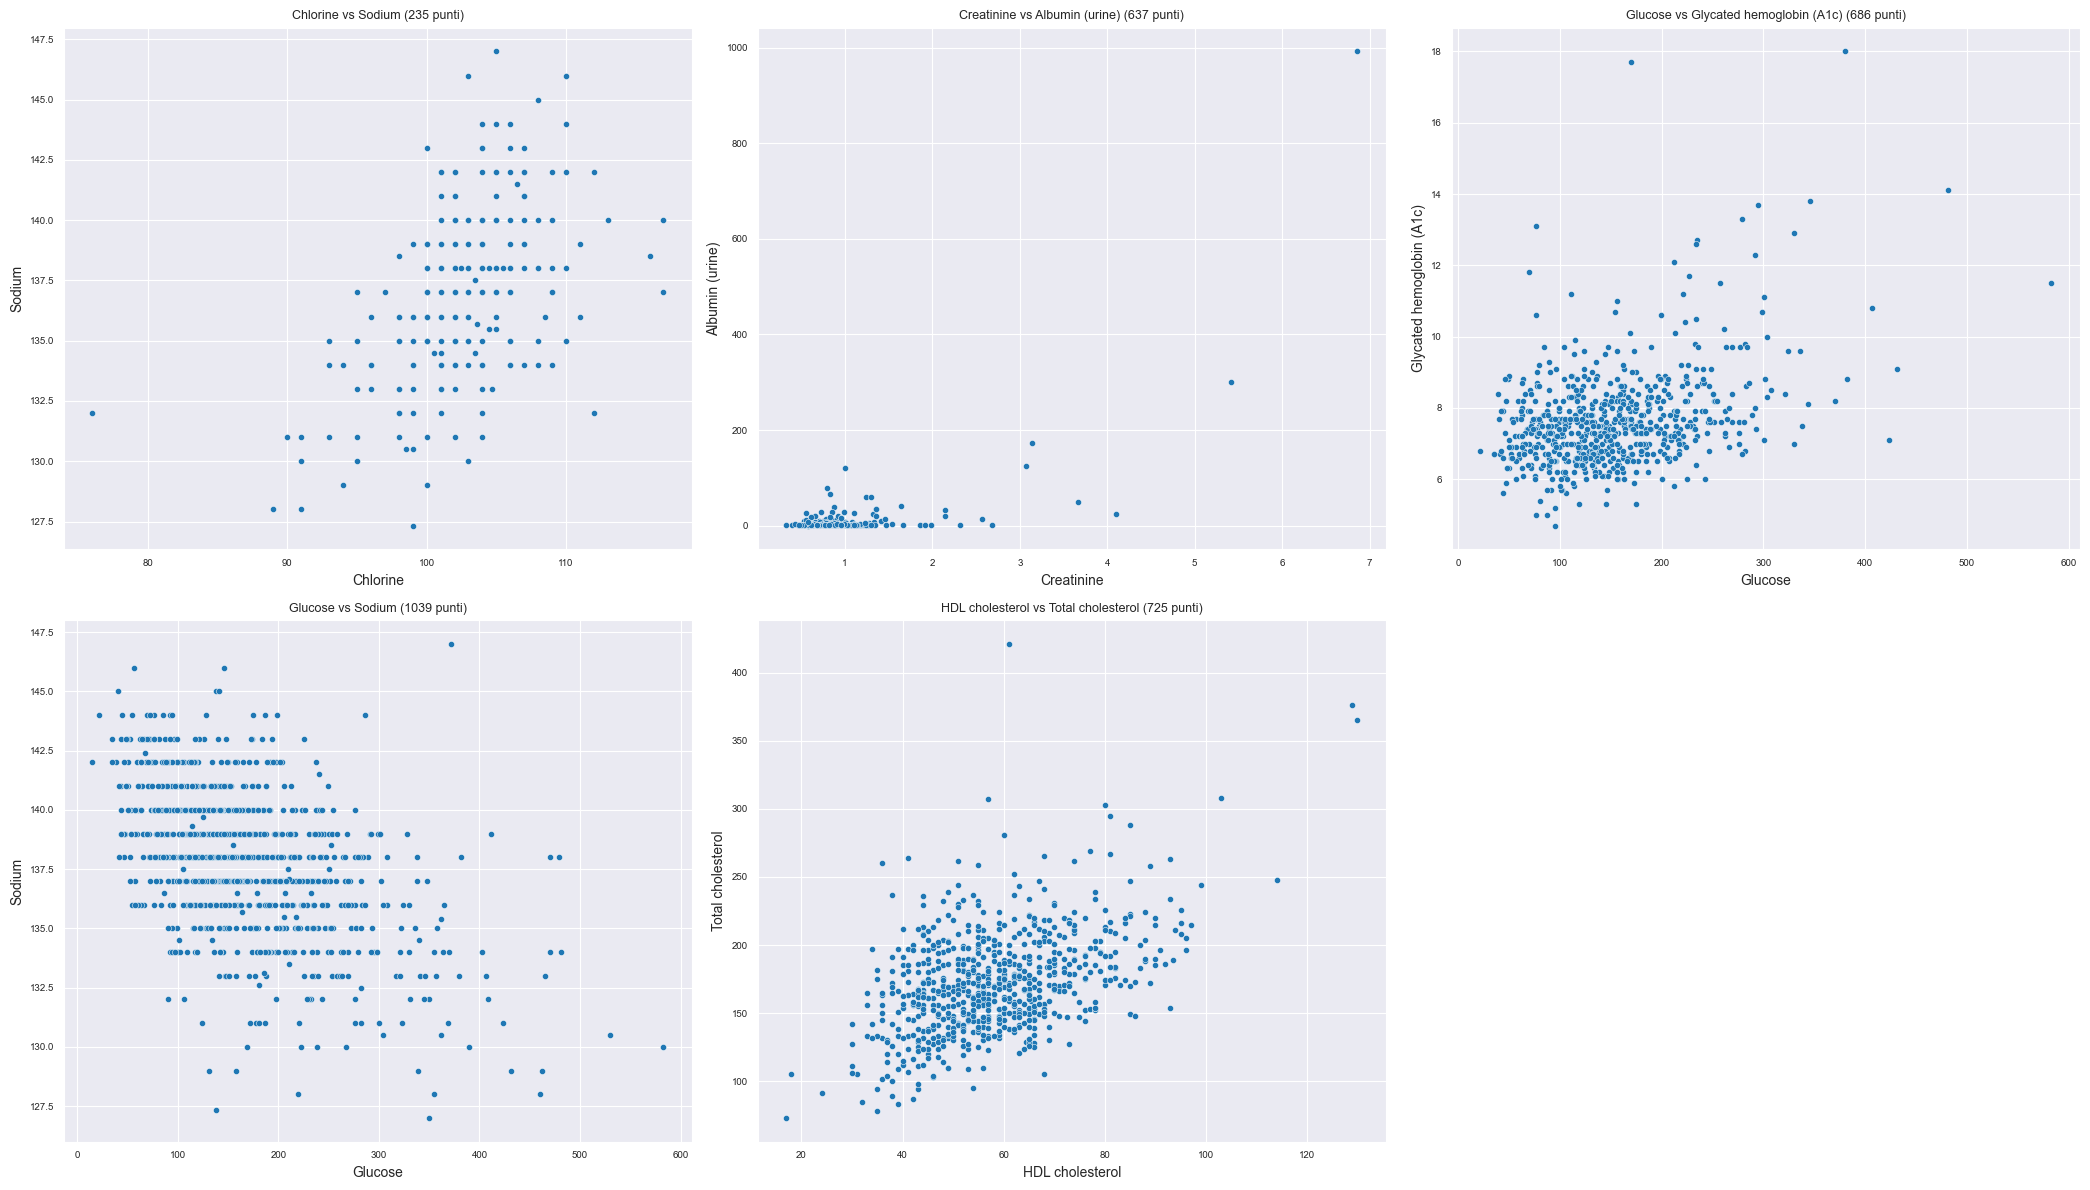

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from datetime import timedelta

# STEP 1: Calcolo correlazioni su dati a 30 giorni
records = []

for patient_id, group in first_dates.groupby("ID"):
    date_dict = group.set_index("Parametro")["Data"].to_dict()
    value_dict = df1[df1["ID"] == patient_id].groupby("Parametro")["Valore"].first().to_dict()

    for p1, p2 in combinations(date_dict.keys(), 2):
        delta_days = abs((date_dict[p1] - date_dict[p2]).days)
        if delta_days <= 30:
            val1 = pd.to_numeric(value_dict.get(p1), errors="coerce")
            val2 = pd.to_numeric(value_dict.get(p2), errors="coerce")
            if pd.notna(val1) and pd.notna(val2):
                records.append({
                    "ID": patient_id,
                    p1: val1,
                    p2: val2
                })

df_corr_raw = pd.DataFrame(records)
df_corr_wide = df_corr_raw.groupby("ID").mean(numeric_only=True)
correlation_matrix = df_corr_wide.corr()

# STEP 2: Estrai coppie con correlazione ≥ 0.35 o ≤ -0.35
threshold = 0.35
correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) >= threshold:
            p1 = correlation_matrix.columns[i]
            p2 = correlation_matrix.columns[j]
            correlation_pairs.append((p1, p2))

# STEP 3: Unisci dataset (senza distinzione complicanze)
df_merged = pd.concat([df_con_complicanze, df_senza_complicanze], ignore_index=True)
df_merged["Valore"] = pd.to_numeric(df_merged["Valore"], errors="coerce")
df_merged["Data"] = pd.to_datetime(df_merged["Data"], errors="coerce")

# Filtra ultimi 90 giorni per ogni paziente
ultimi_tre_mesi = []
for patient_id, group in df_merged.groupby("ID"):
    data_max = group["Data"].max()
    cutoff_date = data_max - timedelta(days=90)
    ultimi_tre_mesi.append(group[group["Data"] >= cutoff_date])

df_merged1 = pd.concat(ultimi_tre_mesi)

# STEP 4: Costruisci i dataframe utili per le coppie con dati
good_pairs = []
pair_data = {}

for (p1, p2) in correlation_pairs:
    if p1 in df_merged1["Parametro"].unique() and p2 in df_merged1["Parametro"].unique():
        df_pair = df_merged1[df_merged1["Parametro"].isin([p1, p2])]

        df_pair_pivot = df_pair.pivot_table(
            index=["ID", "Data"],
            columns="Parametro",
            values="Valore",
            aggfunc="mean"
        ).reset_index()

        df_pair_pivot = df_pair_pivot.dropna(subset=[p1, p2])

        if len(df_pair_pivot) >= 30:
            good_pairs.append((p1, p2))
            pair_data[(p1, p2)] = df_pair_pivot

# STEP 5: Genera scatter plot solo per coppie valide
if not good_pairs:
    print("Nessuna coppia con almeno 30 punti.")
else:
    n = len(good_pairs)
    cols = 3
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 6 * rows))
    axes = axes.flatten()

    for i, (p1, p2) in enumerate(good_pairs):
        df_plot = pair_data[(p1, p2)]
        sns.scatterplot(data=df_plot, x=p1, y=p2, ax=axes[i], s=20)
        axes[i].set_title(f"{p1} vs {p2} ({len(df_plot)} punti)", fontsize=9)
        axes[i].tick_params(labelsize=7)
        axes[i].grid(True)

    # Rimuovi assi vuoti
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Creazione Seconda Parte del Dataset

In [13]:
from datetime import timedelta
import pandas as pd
import numpy as np
import re

# Conversioni sicure
df_merged["Valore"] = pd.to_numeric(df_merged["Valore"], errors="coerce")
df_merged["Data"] = pd.to_datetime(df_merged["Data"], errors="coerce")

# Estrai ID pazienti con "Senza complicanze"
ids_senza_complicanze = df_merged[df_merged["Complicanze"] == "Senza complicanze"]["ID"].unique()
# Seleziona 48 ID casuali
ids_media = np.random.choice(ids_senza_complicanze, size=48, replace=False)

def estrai_numero_da_id(s: str) -> int:
    """Restituisce la parte numerica di un ID come intero. 
       Es. 'LIB194166' → 194166."""
    m = re.search(r'(\d+)$', s)
    return int(m.group(1)) if m else 0

# Calcolo del massimo:
all_ids = df_merged["ID"].astype(str).unique()
numeric_parts = [estrai_numero_da_id(pid) for pid in all_ids]
max_id_num = max(numeric_parts) if numeric_parts else 0

# Partiamo dal contatore successivo
next_id_num = max_id_num + 1

# Selezione dei 48 pazienti senza complicanze per il blocco medio ---
np.random.seed(42)  # Per riproducibilità
ids_media = np.random.choice(df_merged[df_merged["Complicanze"] == "Senza complicanze"]["ID"].unique(), size=48, replace=False)

filtered_records = []
first_period_id_map = {}
mean_period_id_map = {}

for (patient_id, parametro), group in df_merged.groupby(["ID", "Parametro"]):
    group = group.sort_values("Data")
    last_date   = group["Data"].max()
    first_date  = group["Data"].min()
    # Data centrale reale
    group_sorted = group.sort_values("Data").reset_index(drop=True)
    n = len(group_sorted)
    if n == 0:
        continue  # Skip se non ci sono dati
    central_index = n // 2
    mean_date = group_sorted.loc[central_index, "Data"]
    complicanze_val = group["Complicanze"].iloc[0]

    # Ultimi 3 mesi
    cutoff_last = last_date - timedelta(days=90)
    group_last = group[group["Data"] >= cutoff_last]
    filtered_records.append(group_last)
    
    if complicanze_val == "Senza complicanze":
        # Primi 3 mesi
        cutoff_first = first_date + timedelta(days=90)
        block_first = group[group["Data"] <= cutoff_first].copy()
        # Se non ho ancora creato un new_id per questo paziente, lo genero ora
        if patient_id not in first_period_id_map:
            new_id = f"LIB{next_id_num}"
            next_id_num += 1
            first_period_id_map[patient_id] = new_id
        else:
            new_id = first_period_id_map[patient_id]

        block_first["ID"] = new_id
        filtered_records.append(block_first)
        
        # Finestra attorno alla data media (±45 giorni)
        if patient_id in ids_media:
            start_med = mean_date - timedelta(days=45)
            end_med   = mean_date + timedelta(days=45)
            block_media = group[(group["Data"] >= start_med) & (group["Data"] <= end_med)].copy()
            # Se non ho ancora creato un new_id per questo paziente, lo genero ora
            if patient_id not in mean_period_id_map:
                new_id = f"LIB{next_id_num}"
                next_id_num += 1
                mean_period_id_map[patient_id] = new_id
            else:
                new_id = mean_period_id_map[patient_id]
            block_media["ID"] = new_id
            filtered_records.append(block_media)

# Unione dei risultati
df_merged1 = pd.concat(filtered_records)

# Ordinamento e trasformazione come prima
parte2 = df_merged1.sort_values(["ID", "Parametro", "Data"], ascending=False)
parte2["Occorrenza"] = parte2.groupby(["ID", "Parametro"]).cumcount() + 1
parte2["Colonna"] = parte2["Parametro"] + "_" + parte2["Occorrenza"].astype(str)
df_valori = parte2.pivot(index="ID", columns="Colonna", values="Valore")
complicanze = parte2.groupby("ID")["Complicanze"].first()
df_valori.insert(0, "Complicanze", complicanze)
df_valori = df_valori.reset_index()
df_valori.to_csv("parte2.csv", index=False)

In [64]:
df111 = pd.read_csv("parte2.csv")
df111

ID        Complicanze  Alanine transaminase (GPT)_1  \
0    LIB193265  Senza complicanze                           9.0   
1    LIB193266    Con complicanze                          23.0   
2    LIB193267    Con complicanze                          12.0   
3    LIB193268  Senza complicanze                          36.0   
4    LIB193272    Con complicanze                           9.0   
..         ...                ...                           ...   
991  LIB194435  Senza complicanze                          23.0   
992  LIB194436  Senza complicanze                          14.0   
993  LIB194437  Senza complicanze                          17.0   
994  LIB194438  Senza complicanze                          12.0   
995  LIB194439  Senza complicanze                          13.0   

     Alanine transaminase (GPT)_10  Alanine transaminase (GPT)_11  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
..                             ...                            ...   
991                            NaN                            NaN   
992                            NaN                            NaN   
993                            NaN                            NaN   
994                            NaN                            NaN   
995                            NaN                            NaN   

     Alanine transaminase (GPT)_12  Alanine transaminase (GPT)_13  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
..                             ...                            ...   
991                            NaN                            NaN   
992                            NaN                            NaN   
993                            NaN                            NaN   
994                            NaN                            NaN   
995                            NaN                            NaN   

     Alanine transaminase (GPT)_14  Alanine transaminase (GPT)_15  \
0                              NaN                            NaN   
1                              NaN                            NaN   
2                              NaN                            NaN   
3                              NaN                            NaN   
4                              NaN                            NaN   
..                             ...                            ...   
991                            NaN                            NaN   
992                            NaN                            NaN   
993                            NaN                            NaN   
994                            NaN                            NaN   
995                            NaN                            NaN   

     Alanine transaminase (GPT)_16  ...  Triglycerides_5  Triglycerides_6  \
0                              NaN  ...              NaN              NaN   
1                              NaN  ...              NaN              NaN   
2                              NaN  ...              NaN              NaN   
3                              NaN  ...              NaN              NaN   
4                              NaN  ...              NaN              NaN   
..                             ...  ...              ...              ...   
991                            NaN  ...              NaN              NaN   
992                            NaN  ...              NaN              NaN   
993                        

In [65]:
from collections import defaultdict

gruppi = defaultdict(list)

for col in df111.columns:
    match = re.match(r"(.+)_\d+$", col)
    if match:
        radice = match.group(1)
        gruppi[radice].append(col)

# Step 2: Calcola la media per ogni gruppo
for radice, colonne in gruppi.items():
    df111[radice + "_max"] = df111[colonne].max(axis=1)
    df111[radice + "_min"] = df111[colonne].min(axis=1)
    df111.drop(columns=colonne, inplace=True)

# Calcola la percentuale di NaN per colonna
nan_percent = df111.isna().sum() / len(df111) * 100

nan_percent

ID                                       0.000000
Complicanze                              0.000000
Alanine transaminase (GPT)_max           0.200803
Alanine transaminase (GPT)_min           0.200803
Albumin (urine)_max                      1.907631
Albumin (urine)_min                      1.907631
Chlorine_max                            44.979920
Chlorine_min                            44.979920
Creatinine (urine)_max                   1.907631
Creatinine (urine)_min                   1.907631
Creatinine_max                           0.000000
Creatinine_min                           0.000000
Gamma-glutamyl Transferase (GGT)_max     1.204819
Gamma-glutamyl Transferase (GGT)_min     1.204819
Glucose_max                              0.000000
Glucose_min                              0.000000
Glycated hemoglobin (A1c)_max            0.502008
Glycated hemoglobin (A1c)_min            0.502008
HDL cholesterol_max                      1.004016
HDL cholesterol_min                      1.004016


In [66]:
# Tieni solo le colonne con meno del 30% di NaN
columns_to_keep = nan_percent[nan_percent <= 30].index
df111 = df111[columns_to_keep]

# Salva il DataFrame pulito sovrascrivendo il file originale
df111 = df111.drop(columns = (['Complicanze']))
df111.to_csv("Excel/parte2_v4_bilanced.csv", index=False)
df111

ID  Alanine transaminase (GPT)_max  \
0    LIB193265                             9.0   
1    LIB193266                            23.0   
2    LIB193267                            12.0   
3    LIB193268                            36.0   
4    LIB193272                             9.0   
..         ...                             ...   
991  LIB194435                            23.0   
992  LIB194436                            14.0   
993  LIB194437                            17.0   
994  LIB194438                            12.0   
995  LIB194439                            13.0   

     Alanine transaminase (GPT)_min  Albumin (urine)_max  Albumin (urine)_min  \
0                               9.0                 1.80                 1.80   
1                              23.0                 0.70                 0.70   
2                              11.0                 3.02                 3.02   
3                              36.0                 1.76                 1.76   
4                               9.0                 0.70                 0.70   
..                              ...                  ...                  ...   
991                            23.0                 0.70                 0.70   
992                            14.0                 0.70                 0.70   
993                            17.0                 0.70                 0.70   
994                            12.0                 5.98                 5.98   
995                            13.0                 1.01                 1.01   

     Creatinine (urine)_max  Creatinine (urine)_min  Creatinine_max  \
0                    147.37                  147.37            1.24   
1                    138.78                  138.78            1.02   
2                    161.67                  161.67            0.61   
3                    109.00                  109.00            0.60   
4                    168.81                  168.81            0.78   
..                      ...                     ...             ...   
991                  155.96                  155.96            0.77   
992                  128.74                  128.74            0.71   
993                   91.22                   91.22            0.65   
994                  193.59                  193.59            0.66   
995                  222.02                  222.02            0.71   

     Creatinine_min  Gamma-glutamyl Transferase (GGT)_max  ...  Sodium_max  \
0              1.24                                   9.0  ...       137.0   
1              1.02                                  15.0  ...       142.0   
2              0.59                                  20.0  ...       140.0   
3              0.60                                  99.0  ...       137.0   
4              0.78                                  11.0  ...       135.0   
..              ...                                   ...  ...         ...   
991            0.77                                  38.0  ...       142.0   
992            0.71                                  19.0  ...       139.0   
993            0.65                                  18.0  ...       141.0   
994            0.66                                  19.0  ...       137.0   
995            0.71                                  10.0  ...       138.0   

     Sodium_min  Thyrotropin (TSH)_max  Thyrotropin (TSH)_min  \
0         137.0                  2.622                  2.622   
1         142.0                  1.562                  1.562   
2         138.0                  3.157                  2.598   
3         137.0                  0.104                  0.104   
4         135.0                  1.510                  1.510   
..          ...                    ...                    ...   
991       142.0                    NaN                    NaN   
992       139.0                  2.538                  2.538   
993       141.0                  2.537                  2.537  

In [ ]:
df112 = pd.read_csv("parte2_v1.csv")
df112

In [ ]:
# Calcola la percentuale di NaN per colonna
nan_percent = df112.isna().sum()

nan_percent

In [ ]:
df112.isnull().any(axis=1).sum()

In [60]:
df1 = pd.read_csv("Excel/parte2_v2_bilanced.csv")
df2 = pd.read_csv("Excel/parte2_v3_bilanced.csv")

diff = pd.concat([df1, df2]).drop_duplicates(keep=False)
print("Numero di righe diverse:", len(diff))
print(diff)

Numero di righe diverse: 1992
            ID  Alanine transaminase (GPT)_mean  Albumin (urine)_mean  \
0    LIB193265                              9.0                  1.80   
1    LIB193266                             23.0                  0.70   
2    LIB193267                             11.5                  3.02   
3    LIB193268                             36.0                  1.76   
4    LIB193272                              9.0                  0.70   
..         ...                              ...                   ...   
991  LIB194435                              NaN                   NaN   
992  LIB194436                              NaN                   NaN   
993  LIB194437                              NaN                   NaN   
994  LIB194438                              NaN                   NaN   
995  LIB194439                              NaN                   NaN   

     Creatinine (urine)_mean  Creatinine_mean  \
0                     147.37             1.2

### Prima parte dataset BILANCIAMENTO

In [37]:
import pandas as pd

# 1) Carico i dataset
parte1 = pd.read_csv("Excel/Parte1.csv", usecols=["Patient_ID", "Sex", "Age", "Has_Diagnostics"])
glucose = pd.read_csv("Excel/Glucose_measurements.csv")
glucose["Measurement_date"] = pd.to_datetime(glucose["Measurement_date"])

# 2) Preparo la parte “normale”: metriche sugli ultimi 3 mesi come prima
# Calcolo l’ultima data di misurazione per ogni paziente
last_dates = glucose.groupby("Patient_ID")["Measurement_date"].max().rename("LastDate")
glucose = glucose.join(last_dates, on="Patient_ID")

# Filtro le misurazioni degli ultimi 3 mesi
glucose_3m = glucose[glucose["Measurement_date"] >= glucose["LastDate"] - pd.DateOffset(months=3)].copy()

# Funzione di supporto per percentuali
def pct(df, condition):
    total = len(df)
    return (len(df[condition]) / total * 100) if total > 0 else pd.NA

# Calcolo le metriche per gli ultimi 3 mesi
metrics_last3m = (
    glucose_3m
    .groupby("Patient_ID")
    .apply(
        lambda g: pd.Series({
            "%TIR":    pct(g, (g["Measurement"] >= 70)  & (g["Measurement"] <= 180)),
            "%TARLV1": pct(g, (g["Measurement"] >= 181) & (g["Measurement"] <= 249)),
            "%TARLV2": pct(g,  g["Measurement"] >= 250),
            "%TBRLV1": pct(g, (g["Measurement"] >= 54)  & (g["Measurement"] <= 70)),
            "%TBRLV2": pct(g,  g["Measurement"] < 54),
        }),
        include_groups=False
    )
    .reset_index()
)

# 3) Metto insieme parte1 + metriche ultime 3 mesi
df_main = parte1.merge(metrics_last3m, on="Patient_ID", how="left")

# 4) Preparo le aggiunte per i pazienti con Has_Diagnostics == 0,
#    usando i primi 3 mesi di rilevazioni anziché gli ultimi.

# Trovo i Patient_ID già esistenti e estraggo il massimo numero
# (il formato è sempre "LIB" + numero intero).
def extract_num(pid):
    return int(pid.replace("LIB", ""))

all_ids = list(parte1["Patient_ID"].unique())
max_num = max(extract_num(x) for x in all_ids)

# Pre-allocazione lista per i nuovi record
new_rows = []

# Itero sui soli pazienti con Has_Diagnostics == 0
for Patient_ID, r in parte1[parte1["Has_Diagnostics"] == 0].iterrows():
    old_pid = r["Patient_ID"]
    # 4.1) Calcolo il primo e l’ultimo giorno disponibile nel dataset glucose per questo paziente
    df_paz = glucose[glucose["Patient_ID"] == old_pid].copy()
    if df_paz.empty:
        # Se non ci sono rilevazioni per quel paziente, salto
        continue

    first_date = df_paz["Measurement_date"].min()
    cutoff_3m = first_date + pd.DateOffset(months=3)

    # 4.2) Estraggo le misurazioni che cadono nei primi 3 mesi
    df_first3m = df_paz[df_paz["Measurement_date"] <= cutoff_3m].copy()
    if df_first3m.empty:
        # Se non ci sono misurazioni nei primi 3 mesi, salto
        continue

    # 4.3) Calcolo le stesse metriche %TIR, %TARLV1, ecc. sui primi 3 mesi
    met = {
        "%TIR":   pct(df_first3m, (df_first3m["Measurement"] >= 70)  & (df_first3m["Measurement"] <= 180)),
        "%TARLV1": pct(df_first3m, (df_first3m["Measurement"] >= 181) & (df_first3m["Measurement"] <= 249)),
        "%TARLV2": pct(df_first3m,  df_first3m["Measurement"] >= 250),
        "%TBRLV1": pct(df_first3m, (df_first3m["Measurement"] >= 54)  & (df_first3m["Measurement"] <= 70)),
        "%TBRLV2": pct(df_first3m,  df_first3m["Measurement"] < 54),
    }

    # 4.4) Assegno un nuovo Patient_ID incrementale
    max_num += 1
    new_pid = f"LIB{max_num}"

    # 4.5) Costruisco la riga “duplicata” da aggiungere, copiando Sex, Age, Has_Diagnostics
    #      e sostituendo Patient_ID + le metriche nuove.
    new_row = {
        "Patient_ID":      new_pid,
        "Sex":             r["Sex"],
        "Age":             r["Age"],
        "Has_Diagnostics": r["Has_Diagnostics"],
        "%TIR":            met["%TIR"],
        "%TARLV1":         met["%TARLV1"],
        "%TARLV2":         met["%TARLV2"],
        "%TBRLV1":         met["%TBRLV1"],
        "%TBRLV2":         met["%TBRLV2"],
    }
    new_rows.append(new_row)
    
    # 4.6) Se l’ID originale è in ids_media, aggiungo anche la versione centrata su data mediana
    if old_pid in ids_media:
        median_date = df_paz["Measurement_date"].median()
        start_win = median_date - pd.Timedelta(days=45)
        end_win   = median_date + pd.Timedelta(days=45)
        df_median = df_paz[(df_paz["Measurement_date"] >= start_win) &
                           (df_paz["Measurement_date"] <= end_win)].copy()

        if not df_median.empty:
            met_median = {
                "%TIR":    pct(df_median, (df_median["Measurement"] >= 70)  & (df_median["Measurement"] <= 180)),
                "%TARLV1": pct(df_median, (df_median["Measurement"] >= 181) & (df_median["Measurement"] <= 249)),
                "%TARLV2": pct(df_median,  df_median["Measurement"] >= 250),
                "%TBRLV1": pct(df_median, (df_median["Measurement"] >= 54)  & (df_median["Measurement"] <= 70)),
                "%TBRLV2": pct(df_median,  df_median["Measurement"] < 54),
            }

            max_num += 1
            new_pid_median = f"LIB{max_num}"

            new_row_median = {
                "Patient_ID":      new_pid_median,
                "Sex":             r["Sex"],
                "Age":             r["Age"],
                "Has_Diagnostics": r["Has_Diagnostics"],
                "%TIR":            met_median["%TIR"],
                "%TARLV1":         met_median["%TARLV1"],
                "%TARLV2":         met_median["%TARLV2"],
                "%TBRLV1":         met_median["%TBRLV1"],
                "%TBRLV2":         met_median["%TBRLV2"],
            }
            new_rows.append(new_row_median)
    
# 5) Trasformo in DataFrame e concateno
if new_rows:
    df_new = pd.DataFrame(new_rows)
    final_df = pd.concat([df_main, df_new], ignore_index=True)
else:
    final_df = df_main.copy()

# 6) Salvo su CSV
final_df.to_csv("parte1.csv", index=False)

In [38]:
df_parte1 = pd.read_csv("parte1.csv")
(df_parte1['Has_Diagnostics'] == 0).sum()

np.int64(498)